In [1]:
using LinearAlgebra, Plots
import GaussQuadrature.legendre
function GL(m; a=0, b=1) 
    # m points Gauss-Legendre quadrature for [a, b]
    xi, wi = legendre(m)
    return map( t->((a+b)/2 + t*(b-a)/2), xi ), (b-a) * wi / 2
end
function K_quadrature(K, s; m=50) 
    # Creates K matrix according to m quadrature points
    # Method proposed in (Bornemann, 2010)
    x, w = GL(m; a=0, b=s)
    w_sqrt = sqrt.(w)
    return (w_sqrt*w_sqrt') .* map(t->K(t...), [(xi,xj) for xi in x, xj in x]) 
end

"""
K_sinc   : the usual sine kernel
Kp_sinc  : the kernel K^{(0)}
Kpp_sinc : twice derived kernel for p₀ = p₂(0;s)
"""
K_sinc(x, y)    = x==y ? 1.0 : sin( π * (x - y) ) / ( π * (x - y) ) 
Kp_sinc(x, y)   = K_sinc(x, y) - sin(π*x)*sin(π*y)/(π^2*x*y)
Kpp_sinc(s,x,y) = Kp_sinc(x,y) - Kp_sinc(x,s)*Kp_sinc(s,y)/Kp_sinc(s,s);

F₀(s; m=30) = det(I - K_quadrature(Kp_sinc, s; m=m))
p₀(s; m=30) = Kp_sinc(s, s) * det(I - K_quadrature((x,y)->Kpp_sinc(s,x,y), s; m=m));

In [2]:
xs = 0.01:0.01:4;

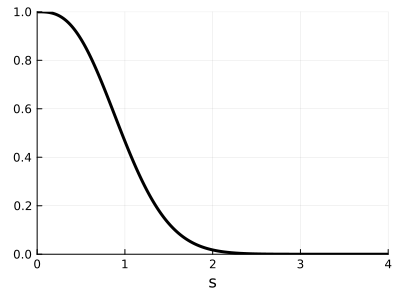

In [3]:
plot(xs, F₀.(xs), xlabel="s", leg=false, lw=3, color=:black, ylims=(0,1), xlims=(0,4), size=(400, 300))
#savefig("F0.pdf")

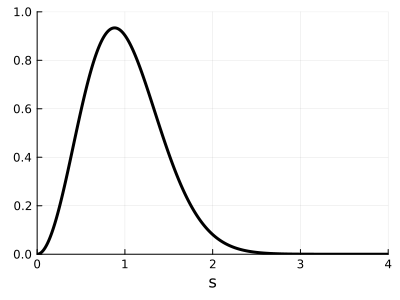

In [4]:
plot(xs, p₀.(xs), xlabel="s", leg=false, lw=3, color=:black, ylims=(0,1), xlims=(0,4), size=(400, 300))
#savefig("p0.pdf")

## Computing moments of $p_0$

In [5]:
function moments_p0(m, mint; b=10)
    x_g, w_g = GL(m; a=0, b=b)
    p₀_g = p₀.(x_g; m=mint);
    Ep = sum(w_g .* x_g .* p₀_g)
    Vp = sum(w_g .* x_g.^2 .* p₀_g) - Ep^2
    σp = sqrt(Vp)
    Sp = sum(w_g .* ((x_g.-Ep)/σp).^3 .* p₀_g)
    Kp = sum(w_g .* ((x_g.-Ep)/σp).^4 .* p₀_g) - 3
    return Ep, Vp, Sp, Kp
end

moments_p0 (generic function with 1 method)

In [6]:
"""
moments_p0(400, 100; b=20)
(1.000000000000004, 0.1799938776918395, 0.4970636204918085, 0.1266998480398942)
"""

@time moments_p0(100, 50)

  0.052166 seconds (3.32 k allocations: 13.951 MiB, 17.51% gc time)


(0.9999999999999989, 0.1799938776918404, 0.4970636204918247, 0.12669984803978895)